In [369]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from shapely.geometry import Point, Polygon
import gmplot

from statsmodels.stats.weightstats import ttest_ind as ttest

from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [272]:
path = ('/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/'+
        'sensing/gps/gps.zip')
zip_file = ZipFile(path)

# Creating dictionary with each file in the zip file loaded into a
# Pandas DataFrame as a value. Keys are the file names
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

# Adding a column to each dataframe that identifies the student id (each
# dataframe represents one student)
for df_key in dfs:
    df = dfs[df_key]
    df['uid'] = df_key

# Concatening all dataframes from dictionary
gps = pd.concat([dfs[df] for df in dfs],
                     sort=False)

In [273]:
# Resetting index away from the unix time column
gps.reset_index(inplace=True)

# Renaming columns
gps.columns = ['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
       'altitude', 'bearing', 'speed', 'travelstate', 'drop_me', 'uid', 'drop_me_too']

# Making sure 'drop_me' and 'drop_me_too' have only empty values
print(gps.drop_me.unique(),
      gps.drop_me_too.unique())

# Dropping extraneous / empty columns
gps.drop(columns=['drop_me', 'drop_me_too'],
         inplace=True)

# Cleaning uid column unless it's already been cleaned
try:
    gps.uid = gps.uid.str.split('gps_u').str.get(1).str.split('.csv').str.get(0).astype(int)
except:
    print('gps.uid already cleaned.')
    
gps.head()

[nan] [nan]


,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,uid
0,1364410654,network,wifi,22.094,43.706605,-72.287042,0.000000,0.0,0.000000,NaN,45
1,1364411866,network,wifi,24.652,43.706598,-72.287005,0.000000,0.0,0.000000,NaN,45
2,1364852743,network,wifi,24.060,43.706614,-72.287039,0.000000,0.0,0.000000,NaN,45
3,1364853942,network,wifi,25.242,43.706603,-72.287025,0.000000,0.0,0.000000,NaN,45
4,1364854001,gps,NaN,14.000,43.707150,-72.286592,199.399994,0.0,0.559017,NaN,45


In [274]:
gps['datetime'] = pd.to_datetime(gps.time, unit='s')

In [426]:
commons = gps.loc[
    ((gps.latitude > 43.702884) &
     (gps.latitude < 43.703264) &
     (gps.longitude > -72.291668) &
     (gps.longitude < -72.290378)
    ) |
    ((gps.latitude > 43.702808) &
     (gps.latitude < 43.703010) &
     (gps.longitude > -72.291287) &
     (gps.longitude < -72.290751)),
    :]
print('{:.1%}'.format(len(commons) / len(gps)))

1.5%


In [428]:
library = gps.loc[
    ((gps.latitude > 43.705063) &
     (gps.latitude < 43.705889) &
     (gps.longitude > -72.289104) &
     (gps.longitude < -72.288189)
    ), :]
print('{:.1%}'.format(len(library) / len(gps)))

3.2%


In [425]:
collins = gps.loc[
    ((gps.latitude > 43.702544) &
     (gps.latitude < 43.703004) &
     (gps.longitude > -72.290304) &
     (gps.longitude < -72.289623)
    ), :]
print('{:.1%}'.format(len(collins) / len(gps)))

0.9%


In [429]:
location = library.copy()

In [347]:
hour_sums = [
    len(location[(location.datetime.dt.hour==hour) &
                (location.datetime.dt.day==day)])
    for hour, day in itertools.product(location.datetime.dt.hour.unique(),
                                       location.datetime.dt.day.unique())
]

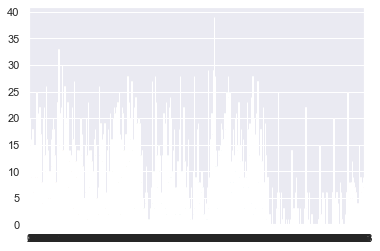

In [348]:
bplot = sns.barplot(
    x=list(range(len(hour_sums))),
    y=hour_sums
)

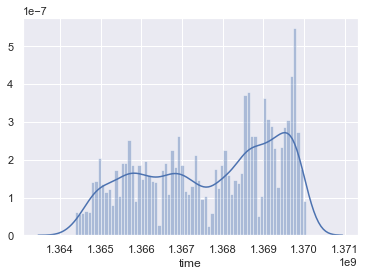

In [430]:
sns.distplot(location.time, bins=70)

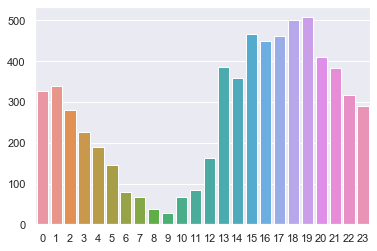

In [350]:
sns.set(style='darkgrid')
bplot = sns.barplot(
    x=location.datetime.dt.hour.unique(),
    y=[len(location[location.datetime.dt.hour==hour])
       for hour in location.datetime.dt.hour.unique()]
)

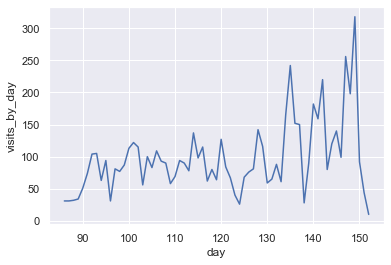

In [351]:
location_df = pd.DataFrame()
location_df['day'] = location.datetime.dt.dayofyear.unique()
location_df['visits_by_day'] = pd.Series([float(len(location[location.datetime.dt.dayofyear==dayofyear]))
                                         for dayofyear in location.datetime.dt.dayofyear.unique()])

bplot = sns.lineplot(
    x=location_df.day,
    y=location_df.visits_by_day
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


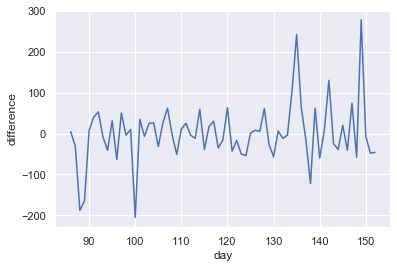

In [352]:
location_df['difference'] = location_df.visits_by_day[1:] - location_df.visits_by_day.shift()
location_df.difference[0] = location_df.visits_by_day.iloc[0].copy()
bplot = sns.lineplot(
    x=location_df.day,
    y=location_df.difference
)

67
67


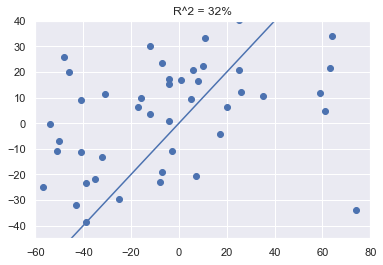

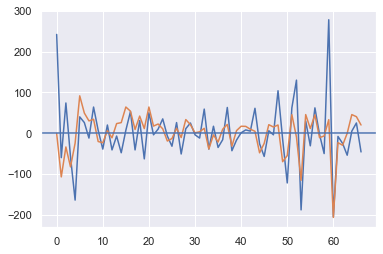

                              ARMA Model Results                              
Dep. Variable:             difference   No. Observations:                   67
Model:                     ARMA(3, 1)   Log Likelihood                -366.904
Method:                       css-mle   S.D. of innovations             56.100
Date:                Tue, 01 Sep 2020   AIC                            745.807
Time:                        17:13:58   BIC                            759.035
Sample:                             0   HQIC                           751.041
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.5990      0.386     -1.551      0.126      -1.356       0.158
ar.L1.difference     0.1274      0.129      0.987      0.327      -0.126       0.380
ar.L2.difference     0.0107 

In [370]:
model = ARIMA(location_df.difference, order=(3,0,1))
model_fit = model.fit(transparams=False)

plt.scatter(x=location_df.difference,
            y=model_fit.fittedvalues)
sns.lineplot(x=model_fit.fittedvalues,
             y=model_fit.fittedvalues)
r2 = metrics.r2_score(location_df.difference,
                      model_fit.fittedvalues)
plt.title('R^2 = {:.0%}'.format(r2))
plt.xlim([-60, 80])
plt.ylim([-45, 40])
plt.show()

plt.plot(location_df.difference)
plt.plot(model_fit.fittedvalues)
plt.axhline(location_df.difference.mean())
plt.show()

print(model_fit.summary())
print('Residuals Description')
print(pd.Series(model_fit.resid).describe())